<a href="https://colab.research.google.com/github/ZhenwenZhang1108/ADL-Assigenment1-Q3/blob/main/sam_lung_xrays_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
# Mount Google drive
try:
    from google.colab import drive
    import os
    drive.mount('/content/gdrive/')
    os.chdir('/content/gdrive/MyDrive/ADL4')
    print(os.listdir())
except:
    print('Google drive not mounted')

Mounted at /content/gdrive/
['models', 'images', '.ipynb_checkpoints', 'yolov8n.pt', 'runs', 'datasets']


In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    !pip install torchmetrics
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

# Chest X-ray Dataset

In [ ]:
import os
from torchvision.datasets.utils import download_url

In [ ]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
# Load database with chest X-rays with lung segmentations.
data_root='/content/gdrive/MyDrive/ADL4/datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

100%|██████████| 80938446/80938446 [00:05<00:00, 15375477.09it/s]


In [ ]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(),cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [ ]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

In [ ]:
import cv2

x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

x_train = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in x_train])
x_train = 255 * (x_train - x_train.min())/(x_train.max()-x_train.min())
x_train = x_train.astype(np.uint8)


x_val = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in x_val])
x_val = 255 * (x_val - x_val.min())/(x_val.max()-x_val.min())
x_val = x_val.astype(np.uint8)


x_test = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in x_test])
x_test = 255 * (x_test - x_test.min())/(x_test.max()-x_test.min()).astype(np.uint8)
x_test = x_test.astype(np.uint8)

In [ ]:
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [ ]:
x_train.dtype

dtype('uint8')

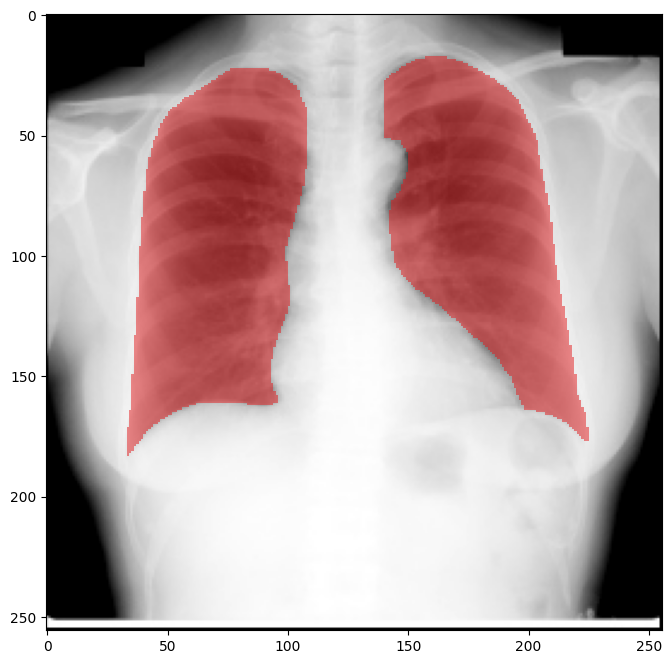

In [ ]:
# Load train/val/test data


# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE


# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[2], y_train[2])
plt.axis('on')
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [ ]:
example_img, example_mask = x_train[4], y_train[4]

input_points = np.array([[170, 75],[70,75]]) # TODO: Pick apropriate input points,
input_label = np.array([1,1]) # TODO: Pick apropriate input labels

example_img.shape

(256, 256, 3)

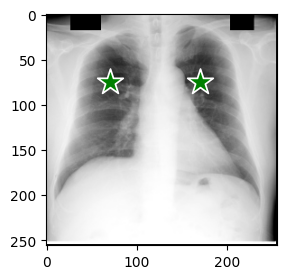

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

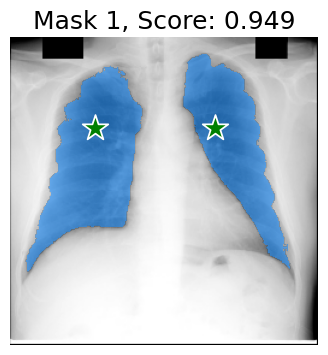

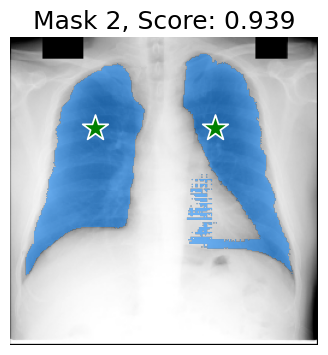

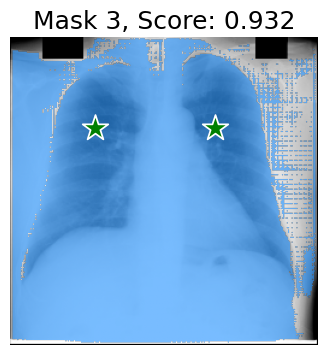

In [ ]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [ ]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores_1 = []
f1_scores_2 = []
f1_scores_3 = []

for (img, mask_gt) in zip(x_val, y_val):
    # raise NotImplementedError("TODO: Predict segmentation with SAM and compute F1 score.")
    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=input_label,
       multimask_output=True,
    )
    f1_scores_1.append(f1(torch.tensor(masks[0]),torch.tensor(mask_gt)))
    f1_scores_2.append(f1(torch.tensor(masks[1]),torch.tensor(mask_gt)))
    f1_scores_3.append(f1(torch.tensor(masks[2]),torch.tensor(mask_gt)))

mean_f1_1 = np.mean(np.array(f1_scores_1)) # TODO: Compute mean F1 score
std_f1_1 = np.std(np.array(f1_scores_1)) # TODO: Compute standard deviation of F1 scores

mean_f1_2 = np.mean(np.array(f1_scores_2)) # TODO: Compute mean F1 score
std_f1_2 = np.std(np.array(f1_scores_2))

mean_f1_3 = np.mean(np.array(f1_scores_3)) # TODO: Compute mean F1 score
std_f1_3 = np.std(np.array(f1_scores_3))

print(f"Mean F1 score 1: {mean_f1_1:.4f}")
print(f"Standard deviation 1: {std_f1_1:.4f}")
print(f"Mean F1 score 2: {mean_f1_2:.4f}")
print(f"Standard deviation 2: {std_f1_2:.4f}")
print(f"Mean F1 score 3: {mean_f1_3:.4f}")
print(f"Standard deviation 3: {std_f1_3:.4f}")

Mean F1 score 1: 0.8552
Standard deviation 1: 0.0782
Mean F1 score 2: 0.6721
Standard deviation 2: 0.1351
Mean F1 score 3: 0.5193
Standard deviation 3: 0.0796


# Using Bounding Boxes from GT segmentations as Prompt

In [ ]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks
example_img, example_mask = x_train[1], y_train[1]
input_boxes = torch.tensor([[25,25,140,215],[140,25,220,205]],device=predictor.device)
predictor.set_image(example_img)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

# GT模型--自行生产boxes

In [ ]:
def gt_box(y_target):
  colrecord = list()
  col_sum = np.sum(y_target, axis=0)
  col = np.argwhere(col_sum==0)
  for x in range(1,len(col)):
    if(col[x]-col[x-1]!=1): colrecord.append(col[x-1][0]),colrecord.append(col[x][0]-1)
#left
  rowrecord1 = list()
  row1 = np.sum(y_target[:,colrecord[0]:colrecord[1]], axis=1)
  row1 = np.insert(row1, 0, [0])
  row1 = np.append(row1,0)
  row1 = np.argwhere(row1==0)

  for x in range(1,len(row1)):
    if(row1[x]-row1[x-1]!=1): rowrecord1.append(row1[x-1][0]-1),rowrecord1.append(row1[x][0]-2)
#right
  rowrecord2 = list()
  row2 = np.sum(y_target[:,colrecord[2]:colrecord[3]], axis=1)
  row2 = np.append(row2,0)
  row2 = np.argwhere(row2==0)
  for x in range(1,len(row2)):
    if(row2[x]-row2[x-1]!=1): rowrecord2.append(row2[x-1][0]),rowrecord2.append(row2[x][0]-1)

  return [[colrecord[0],rowrecord1[0],colrecord[1],rowrecord1[-1]],[colrecord[2],rowrecord2[0],colrecord[3],rowrecord2[-1]]]

In [ ]:
example_img, example_mask = x_train[2], y_train[2]
input_boxes = torch.tensor(gt_box(example_mask),device=predictor.device)
predictor.set_image(example_img)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

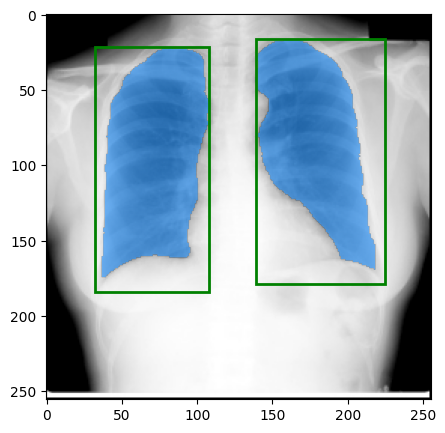

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(x_train[2])
show_box(gt_box(y_train[2])[0], plt.gca()) # You may also use other prompt methods!
show_box(gt_box(y_train[2])[1], plt.gca())
show_mask(masks[0].cpu()+masks[1].cpu(),plt.gca())
plt.axis('on')
plt.show()

In [ ]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")
f1_scores = []

for (img, mask_gt) in zip(x_val, y_val):
    input_boxes = torch.tensor(gt_box(mask_gt),device=predictor.device)
    predictor.set_image(img)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
    masks, scores, logits = predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=transformed_boxes,
      multimask_output=False,
    )

    f1_scores.append(f1((masks[0].cpu()+masks[1].cpu()).squeeze(),torch.tensor(mask_gt)))

mean_f1 = np.mean(np.array(f1_scores))
std_f1 = np.std(np.array(f1_scores))

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

# Object Detection Model to predict Bounding Boxes

In [ ]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes
import torch
from torchvision import models, transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#transforms = image_transforms()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

model.to(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 193MB/s]


In [ ]:
from torch.utils.data import Dataset,DataLoader,random_split
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        self.box = []
        self.labels = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        target = {}
        target["boxes"] = self.box[index]
        target["labels"] = self.labels[index]

        return self.data[index], target

    def append(self, data, target, score):
        self.data.append(data)
        self.box.append(target)
        self.labels.append(score)

train_dataset = CustomDataset()

for i in range(0,len(x_train)):
  train_dataset.append(torch.tensor(x_train[i]).permute(2,0,1),torch.tensor(gt_box(y_train[i])),torch.ones((2,),dtype=torch.int64))



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [ ]:
import torch.optim as optim
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
trans = FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()

In [ ]:
model.to(device)
model.train()
for i in range(1,10):
  for q,t in train_dataloader:
   q = q.to(device)
   res = model(trans(q),[{"boxes": box, "labels": label} for box, label in zip(t["boxes"].to(device), t["labels"].to(device))])
   losses = res['loss_classifier']+res['loss_box_reg']+res['loss_objectness']+res['loss_rpn_box_reg']
   optimizer.zero_grad()
   losses.backward()
   optimizer.step()

In [ ]:
model.eval()
model.to('cpu')
img = torch.tensor(x_train[2]).unsqueeze(0).permute(0,3,1,2)
results = model(trans(img))
print(results)

[{'boxes': tensor([[ 32.7994,  21.8608, 107.2955, 184.9958],
        [139.3008,  17.4496, 224.6589, 177.6127]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1]), 'scores': tensor([0.9995, 0.9994], grad_fn=<IndexBackward0>)}]


In [ ]:
#torch.save(model.state_dict(), './model_trained.pth')

In [ ]:
example_img, example_mask = x_train[10], y_train[10]
img = torch.tensor(x_train[10],dtype=torch.float32).unsqueeze(0).permute(0,3,1,2)
results = model(img/255)
input_boxes = torch.tensor(results[0]['boxes'][0:2],device=predictor.device)
predictor.set_image(example_img)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
ma = masks[0]+masks[1]

<ipython-input-94-37f4da211d40>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_boxes = torch.tensor(results[0]['boxes'][0:2],device=predictor.device)


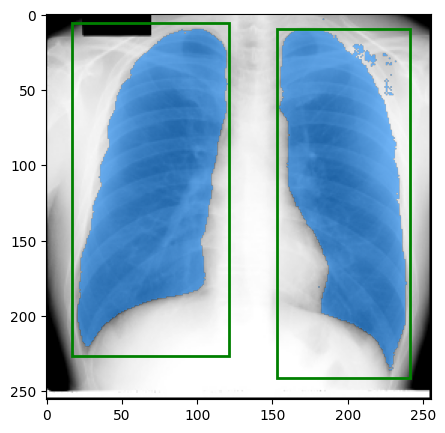

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(x_train[10])
show_box(results[0]['boxes'][1].detach().numpy(), plt.gca())
show_box(results[0]['boxes'][0].detach().numpy(), plt.gca())
show_mask(ma.cpu(),plt.gca())
plt.axis('on')
plt.show()



In [ ]:
def IoU_loss(M,N):
  loss = torchvision.ops.box_iou(M,N).squeeze()
  return max((loss[0,0]+loss[1,1])/2,(loss[1,0]+loss[0,1])/2)

In [ ]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")
f1_scores = []
Iou = 0.0
for (img, mask_gt) in zip(x_val, y_val):

    example_img, example_mask = img, mask_gt
    img = torch.tensor(img,dtype=torch.float32).unsqueeze(0).permute(0,3,1,2)
    results = model(img/255)
    input_boxes = torch.tensor(results[0]['boxes'][0:2],device=predictor.device)
    predictor.set_image(example_img)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
    masks, scores, logits = predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=transformed_boxes,
      multimask_output=False,
    )
    ma = masks[0]+masks[1]
    Iou = Iou + IoU_loss(torch.tensor(gt_box(example_mask)),torch.tensor(results[0]['boxes'][0:2]))
    f1_scores.append(f1((ma.cpu()).squeeze(),torch.tensor(mask_gt)))

mean_f1 = np.mean(np.array(f1_scores))
std_f1 = np.std(np.array(f1_scores))

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")
print(Iou/len(y_val))

<ipython-input-27-cdcddae00c99>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_boxes = torch.tensor(results[0]['boxes'][0:2],device=predictor.device)
<ipython-input-27-cdcddae00c99>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Iou = Iou + IoU_loss(torch.tensor(gt_box(example_mask)),torch.tensor(results[0]['boxes'][0:2]))


Mean F1 score: 0.9216
Standard deviation: 0.0237
tensor(0.9358)
